In [1]:
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from scipy.ndimage import rotate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sklearn
import math
from sklearn.model_selection import train_test_split
print(f"Tensorflow version: \t{tf.__version__}")
print(f"Keras version: \t\t\t{keras.__version__}")

seed = 19
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Tensorflow version: 	2.20.0
Keras version: 			3.11.3


In [2]:
# Load data

images = np.load("../../data/images.npy")
labels = np.load("../../data/labels.npy")

In [3]:
def augment_images(images, labels):
    aug_imgs = [images]
    aug_labels = [labels]
    temp = []

    for img in images:
        aug_img = img.copy()
        aug_img = rotate(aug_img, angle=random.uniform(1, 360), reshape=False, mode="nearest", order=1)
        temp.append(aug_img)

    aug_imgs.append(np.array(temp))
    aug_labels.append(labels.copy())

    return np.vstack(aug_imgs), np.vstack(aug_labels)

def show_augmented_comparison(images, labels, n):
    half = len(images)//2
    indices = np.arange(half)
    np.random.shuffle(indices)

    images_normal = images[:half][indices]
    images_aug = images[half:][indices]
    labels_normal = labels[:half][indices]
    labels_aug = labels[half:][indices]

    images_shuffled = np.vstack([images_normal, images_aug])
    labels_shuffled = np.vstack([labels_normal, labels_aug])

    for i in range(n):
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images_shuffled[i], cmap='gray')
        plt.xlabel(f"Original: {labels_shuffled[i]}")

        # Augmented image (still corresponds to same original)
        plt.subplot(1, 2, 2)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images_shuffled[i + half], cmap='gray')
        plt.xlabel(f"Augmented: {labels_shuffled[i + half]}")

        plt.tight_layout()
        plt.show()

In [4]:
# Process to segment into train, test, and validation sets
images, labels = augment_images(images, labels)
print(images.shape, len(labels))
images = images / 255.0

X_train, X_temp, y_train, y_temp = train_test_split(images,labels,
                                         random_state=19,
                                         test_size=0.2,
                                         shuffle=True,
                                         stratify=labels)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                       test_size=0.5,
                                       shuffle=True,
                                       stratify=y_temp)



(36000, 75, 75) 36000


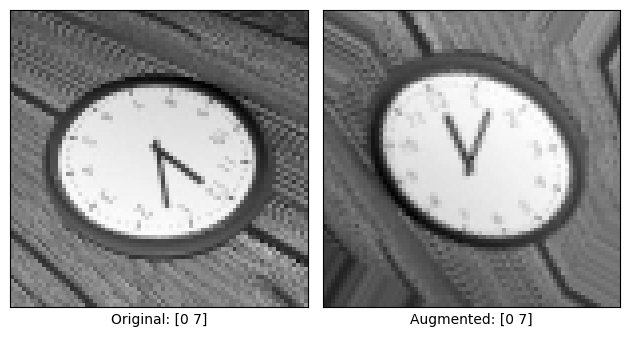

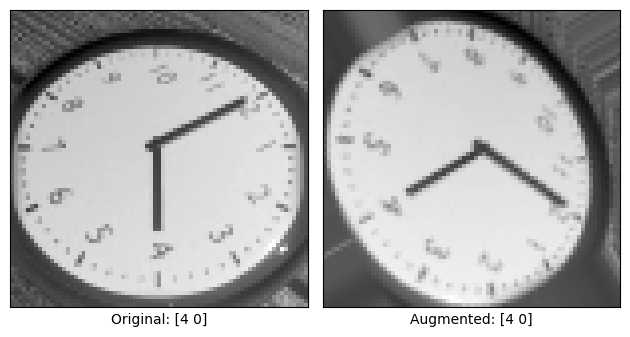

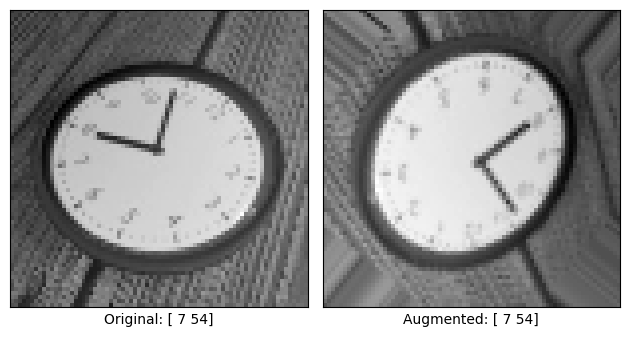

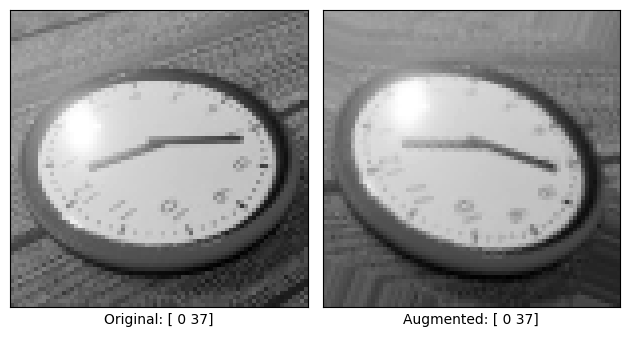

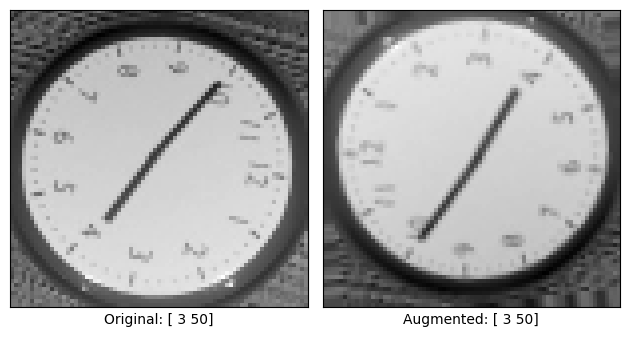

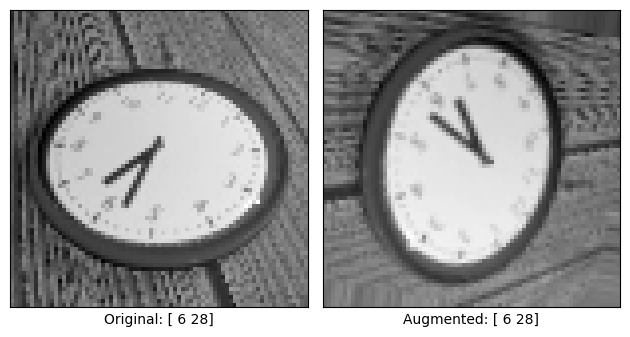

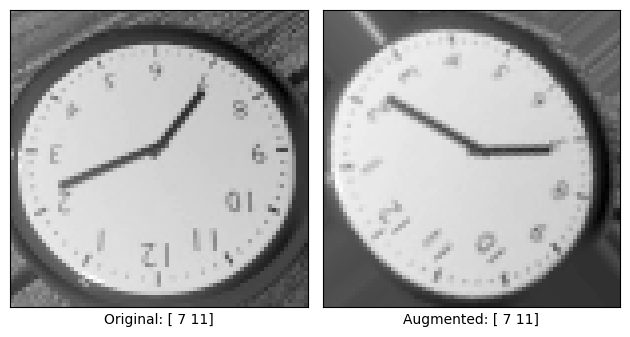

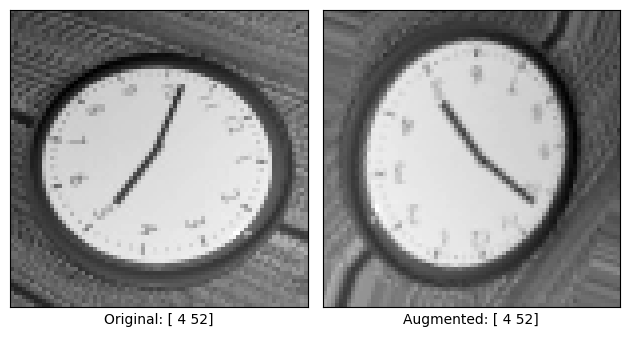

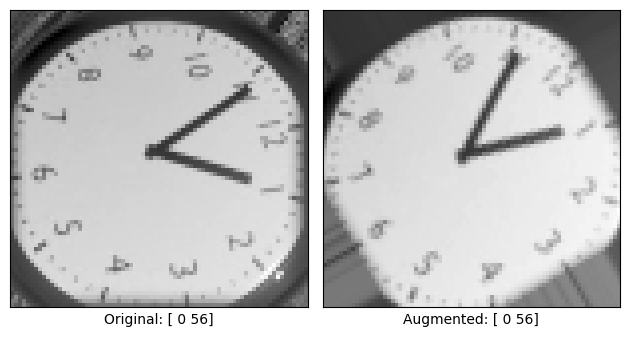

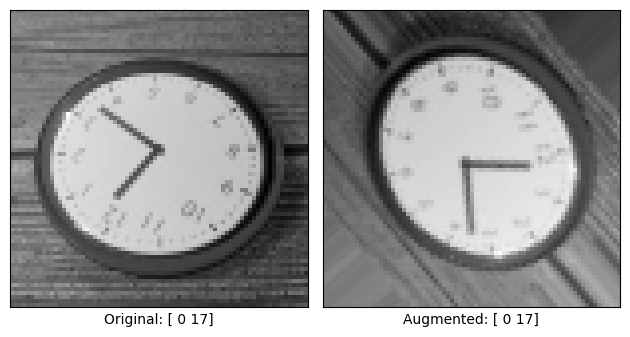

In [5]:
show_augmented_comparison(images, labels, 10)

In [6]:
print(X_train.shape, len(y_train))
print(X_val.shape, len(y_val))
print(X_test.shape, len(y_test))

(28800, 75, 75) 28800
(3600, 75, 75) 3600
(3600, 75, 75) 3600


In [7]:
def class_convert(y, interval=30, clock=12*60):
    vals = []
    # You can use the class labels to correspond to different classes after cnn output
    class_labels = np.array([[i, j] for i in range(int(clock/60)) for j in [0, interval]])

    for hr, min in y:
        # Assigns a value in range 0, 23 for each hour minute combination, resulting in 24*60/interval classes. 0 for 0-30 min, 1 for 30 min-1 hr for interval=30, etc.
        classification_val = math.floor(min/interval + hr*60/interval)
        vals.append(classification_val)
        # Shows all values lock to the first floor
        # print(f"{hr:02d}:{min:02d} = {class_labels[classification_val]}")
        # print(f"Actual value: {hr} hours, {min} minutes")
        # print(f"Corresponding label for classification: {classification_val}")

    return np.array(vals), class_labels

conv_y_test, class_labels = class_convert(y_test)
conv_y_train, _ = class_convert(y_train)
conv_y_val, _ = class_convert(y_val)

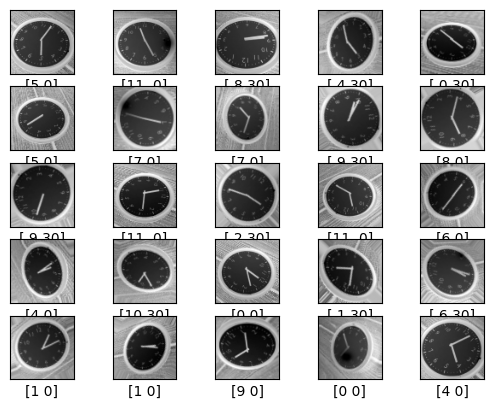

In [8]:
# Plotting with some code from tensorflow.org

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(1 - X_val[i], cmap="gray")
    plt.xlabel(class_labels[conv_y_val[i]])
    # plt.xlabel(y_val[i])
    # print(f"{class_labels[conv_y_val[i]]} = {y_val[i]}" )
plt.show()

In [9]:
# Creating the CNN model
width, height = X_train.shape[1], X_train.shape[2]
n_classes = len(class_labels)

model = models.Sequential([
    layers.Input(shape=(height, width, 1)),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 4 (optional - add if images are large, e.g., 200x200+)
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 75, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,668,344 (6.36 MB)

 Trainable params: 1,667,384 (6.36 MB)

 Non-trainable params: 960 (3.75 KB)

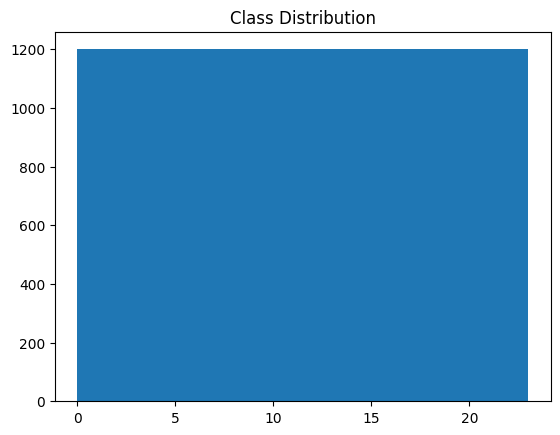

In [10]:
# Just to check class imbalances

plt.hist(conv_y_train, bins=n_classes)
plt.title('Class Distribution')
plt.show()

In [11]:
# train model


# print(X_train.shape)
# print(X_train[0].shape)
# print(type(conv_y_train))
# print(len(conv_y_train))
# print(f"X_train type: {type(X_train)}")
# print(X_train)

start_time = time.time()

history = model.fit(
    X_train, conv_y_train,
    validation_data=(X_val, conv_y_val),
    epochs=20,
    batch_size=16,
    verbose=2
)

end_time = time.time()

print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

Epoch 1/20
1800/1800 - 320s - 178ms/step - accuracy: 0.0395 - loss: 3.1955 - val_accuracy: 0.0397 - val_loss: 3.1782
Epoch 2/20
1800/1800 - 348s - 193ms/step - accuracy: 0.0389 - loss: 3.1785 - val_accuracy: 0.0417 - val_loss: 3.1781
Epoch 3/20
1800/1800 - 353s - 196ms/step - accuracy: 0.0385 - loss: 3.1808 - val_accuracy: 0.0417 - val_loss: 3.1781
Epoch 4/20
1800/1800 - 350s - 195ms/step - accuracy: 0.0413 - loss: 3.1785 - val_accuracy: 0.0417 - val_loss: 3.1781
Epoch 5/20
1800/1800 - 331s - 184ms/step - accuracy: 0.0382 - loss: 3.1789 - val_accuracy: 0.0417 - val_loss: 3.1781
Epoch 6/20
1800/1800 - 322s - 179ms/step - accuracy: 0.0403 - loss: 3.1784 - val_accuracy: 0.0417 - val_loss: 3.1781
Epoch 7/20
1800/1800 - 329s - 183ms/step - accuracy: 0.0397 - loss: 3.1784 - val_accuracy: 0.0417 - val_loss: 3.1781
Epoch 8/20
1800/1800 - 329s - 183ms/step - accuracy: 0.0385 - loss: 3.1783 - val_accuracy: 0.0417 - val_loss: 3.1781
Epoch 9/20
1800/1800 - 323s - 180ms/step - accuracy: 0.0395 - lo


KeyboardInterrupt

